In [ ]:
import scipy
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

In [2]:
from scipy.sparse import issparse
import numpy as np
import pandas as pd

def gower_matrix(data_x, data_y=None, weight=None, cat_features=None):  
    
    # function checks
    X = data_x
    if data_y is None: Y = data_x 
    else: Y = data_y 
    if not isinstance(X, np.ndarray): 
        if not np.array_equal(X.columns, Y.columns): raise TypeError("X and Y must have same columns!")   
    else: 
         if not X.shape[1] == Y.shape[1]: raise TypeError("X and Y must have same y-dim!")  
                
    if issparse(X) or issparse(Y): raise TypeError("Sparse matrices are not supported!")        
            
    x_n_rows, x_n_cols = X.shape
    y_n_rows, y_n_cols = Y.shape 
    
    if cat_features is None:
        if not isinstance(X, np.ndarray): 
            is_number = np.vectorize(lambda x: not np.issubdtype(x, np.number))
            cat_features = is_number(X.dtypes)    
        else:
            cat_features = np.zeros(x_n_cols, dtype=bool)
            for col in range(x_n_cols):
                if not np.issubdtype(type(X[0, col]), np.number):
                    cat_features[col]=True
    else:          
        cat_features = np.array(cat_features)
    
    # print(cat_features)
    
    if not isinstance(X, np.ndarray): X = np.asarray(X)
    if not isinstance(Y, np.ndarray): Y = np.asarray(Y)
    
    Z = np.concatenate((X,Y))
    
    x_index = range(0,x_n_rows)
    y_index = range(x_n_rows,x_n_rows+y_n_rows)
    
    Z_num = Z[:,np.logical_not(cat_features)]
    
    num_cols = Z_num.shape[1]
    num_ranges = np.zeros(num_cols)
    num_max = np.zeros(num_cols)
    
    for col in range(num_cols):
        col_array = Z_num[:, col].astype(np.float32) 
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)
     
        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        num_max[col] = max
        num_ranges[col] = np.abs(1 - min / max) if (max != 0) else 0.0

    # This is to normalize the numeric values between 0 and 1.
    Z_num = np.divide(Z_num ,num_max,out=np.zeros_like(Z_num), where=num_max!=0)
    Z_cat = Z[:,cat_features]
    
    if weight is None:
        weight = np.ones(Z.shape[1])
        
    #print(weight)    
    
    weight_cat=weight[cat_features]
    weight_num=weight[np.logical_not(cat_features)]   
        
    out = np.zeros((x_n_rows, y_n_rows), dtype=np.float32)
        
    weight_sum = weight.sum()
    
    X_cat = Z_cat[x_index,]
    X_num = Z_num[x_index,]
    Y_cat = Z_cat[y_index,]
    Y_num = Z_num[y_index,]
    
   # print(X_cat,X_num,Y_cat,Y_num)
    
    for i in range(x_n_rows):          
        j_start= i        
        if x_n_rows != y_n_rows:
            j_start = 0
        # call the main function
        res = gower_get(X_cat[i,:], 
                          X_num[i,:],
                          Y_cat[j_start:y_n_rows,:],
                          Y_num[j_start:y_n_rows,:],
                          weight_cat,
                          weight_num,
                          weight_sum,
                          cat_features,
                          num_ranges,
                          num_max) 
        #print(res)
        out[i,j_start:]=res
        if x_n_rows == y_n_rows: out[i:,j_start]=res
        
    return out


def gower_get(xi_cat,xi_num,xj_cat,xj_num,feature_weight_cat,
              feature_weight_num,feature_weight_sum,categorical_features,
              ranges_of_numeric,max_of_numeric ):
    
    # categorical columns
    sij_cat = np.where(xi_cat == xj_cat,np.zeros_like(xi_cat),np.ones_like(xi_cat))
    sum_cat = np.multiply(feature_weight_cat,sij_cat).sum(axis=1) 

    # numerical columns
    abs_delta=np.absolute(xi_num-xj_num)
    sij_num=np.divide(abs_delta, ranges_of_numeric, out=np.zeros_like(abs_delta), where=ranges_of_numeric!=0)

    sum_num = np.multiply(feature_weight_num,sij_num).sum(axis=1)
    sums= np.add(sum_cat,sum_num)
    sum_sij = np.divide(sums,feature_weight_sum)
    
    return sum_sij

def smallest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    #n += 1
    flat = np.nan_to_num(ary.flatten(), nan=999)
    indices = np.argpartition(-flat, -n)[-n:]
    indices = indices[np.argsort(flat[indices])]
    #indices = np.delete(indices,0,0)
    values = flat[indices]
    return {'index': indices, 'values': values}

def gower_topn(data_x, data_y=None, weight=None, cat_features=None, n = 5):
    
    if data_x.shape[0] >= 2: TypeError("Only support `data_x` of 1 row. ")  
    dm = gower_matrix(data_x, data_y, weight, cat_features)
          
    return smallest_indices(np.nan_to_num(dm[0], nan=1),n)

In [12]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

In [14]:
distance = gower_matrix(df)

In [15]:
distance

array([[0.        , 0.06597222, 0.06326506, ..., 0.4978225 , 0.47504708,
        0.4310852 ],
       [0.06597222, 0.        , 0.03895951, ..., 0.45962808, 0.52018595,
        0.39289078],
       [0.06326506, 0.03895951, 0.        , ..., 0.49858758, 0.5174788 ,
        0.43185028],
       ...,
       [0.4978225 , 0.45962808, 0.49858758, ..., 0.        , 0.10222457,
        0.06673729],
       [0.47504708, 0.52018595, 0.5174788 , ..., 0.10222457, 0.        ,
        0.1272952 ],
       [0.4310852 , 0.39289078, 0.43185028, ..., 0.06673729, 0.1272952 ,
        0.        ]], shape=(150, 150), dtype=float32)

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Number of clusters: 3
Number of noise points: 0


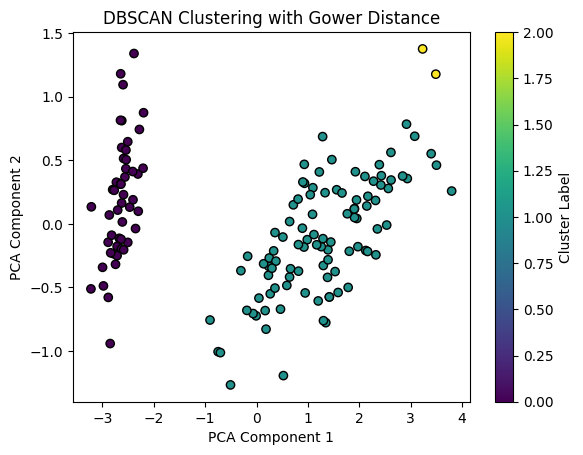

In [23]:
dbscan = DBSCAN(metric='precomputed', eps=0.1, min_samples=2)
dbscan.fit(distance)
labels = dbscan.labels_

# Analyze results
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

# Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('DBSCAN Clustering with Gower Distance')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()